<a href="https://colab.research.google.com/github/Hekapoo-10/boomshaka/blob/main/heart_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# Import library yang dibutuhkan untuk manipulasi data dan perhitungan matematika
import numpy as np
import pandas as pd
import sklearn as sk
import os
from google.colab import drive
drive.mount('/content/drive')


# Path ke file dataset penyakit jantung
input_dataset = "/content/drive/MyDrive/projek akhir/dataset_penyakit_jantung.csv" # Assuming this is the correct path
# Definisi nama kolom sesuai dengan atribut dalam dataset
nama_kolom = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
# Membaca dataset dengan pandas, skip baris header dan gunakan nama kolom yang telah didefinisikan
data = pd.read_csv(input_dataset, skiprows = 1, header = None, names = nama_kolom)

class Node():
    # Kelas Node untuk menyimpan informasi setiap node dalam decision tree
    def __init__(self, feature_index = None, threshold = None, left = None, right = None, info_gain = None, value = None):
        # feature_index: indeks fitur yang digunakan untuk split
        # threshold: nilai batas untuk pemisahan node
        # left: subtree kiri
        # right: subtree kanan
        # info_gain: nilai information gain dari split ini
        # value: nilai prediksi jika node adalah leaf

        # Atribut untuk node keputusan (internal node)
        self.feature_index = feature_index  # Indeks fitur yang digunakan
        self.threshold = threshold          # Nilai threshold untuk split
        self.left = left                   # Pointer ke anak kiri
        self.right = right                 # Pointer ke anak kanan
        self.info_gain = info_gain         # Information gain dari split

        # Atribut untuk node daun (leaf node)
        self.value = value                 # Nilai kelas mayoritas pada leaf

class decision_tree_classifier():
    # Kelas utama untuk Decision Tree Classifier
    def __init__(self, min_samples_split=2, max_depth=2, mode="gini"):
        # min_samples_split: minimum sampel untuk melakukan split
        # max_depth: kedalaman maksimum tree
        # mode: metode perhitungan impurity (gini/entropy)

        # Inisialisasi root tree
        self.root = None

        # Parameter untuk kondisi penghentian (stopping criteria)
        self.min_samples_split = min_samples_split  # Minimum sampel untuk split
        self.max_depth = max_depth                  # Maksimum kedalaman tree
        self.mode = mode                           # Mode impurity calculation

    #fungsi rekursif untuk membangun tree
    def build_tree(self, dataset, curr_depth = 0):

        X, Y = dataset[:,:-1],dataset[:,-1]
        num_samples, num_features = np.shape(X)

        # pisah sampai ketemu kondisi stop
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            # cari pemisah terbaik
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # cek apakah informasi gain positif
            if best_split["info_gain"] > 0:
                # isi node kiri
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                # isi node kanan
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)

                return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree, best_split["info_gain"])

        # hitung node leaf
        leaf_value = self.calculate_leaf_value(Y)

        return Node(value = leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):

        best_split = {}
        max_info_gain = -float("inf")

        # hitung semua feature (mencari entropy tertinggi untuk digunakan memecah tree)
        for feature_index in range (num_features):
            feature_values = dataset[:,feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop semua nilai feature pada data saat ini
            for threshold in possible_thresholds:
                # dapatkan pemecah
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # cek apakah child tidak kosong (null)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # hitung informasi gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, self.mode)
                    # update info gain jika diperlukan
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split

    def split(self, dataset, feature_index, threshold):

        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode = "entropy"):

        weight_l = len(l_child)/len(parent)
        weight_r = len(r_child)/len(parent)
        if mode == "gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))

        return gain

    def entropy(self, y):

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y==cls])/len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y==cls])/len(y)
            gini += p_cls**2

        return 1 - gini

    def calculate_leaf_value(self, Y):

        Y = list(Y)
        return max(Y, key = Y.count)

    def print_tree(self,tree = None, indent = " "):

        if not tree:
            tree = self.root
        if tree.value is not None:
            print(tree.value)
        else:
            print("X_" + str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end = "")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end = "")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):

        dataset = np.concatenate((X,Y), axis = 1)
        self.root = self.build_tree(dataset)

    def predict(self, X):

        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):

        if tree.value!= None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

# Persiapan data untuk training
X = data.iloc[:,:-1].values    # Mengambil semua kolom kecuali target sebagai fitur
Y = data.iloc[:,-1].values.reshape(-1,1)  # Mengambil kolom target dan reshape menjadi vector kolom

# Split data menjadi training dan testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.2, random_state=42)

# Inisialisasi dan training model
classifier = decision_tree_classifier(min_samples_split=3, max_depth=3, mode="entropy")
classifier.fit(X_train,Y_train)  # Melatih model dengan data training
classifier.print_tree()          # Menampilkan struktur tree yang terbentuk

# Evaluasi model
Y_pred = classifier.predict(X_test)  # Melakukan prediksi pada data testing
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)  # Menghitung akurasi model
print("Akurasi:", accuracy_score(Y_test, Y_pred))  # Menampilkan hasil akurasi


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_2 <= 3.0 ? 0.2016620571872162
 left:X_11 <= 0.6 ? 0.09608376974560595
  left:X_9 <= 0.7 ? 0.061599631743289196
    left:X_2 <= 1.0 ? 0.042967525060018164
        left:0.0
        right:0.0
    right:X_10 <= 1.6 ? 0.1594955825677059
        left:0.0
        right:0.0
  right:X_9 <= 2.0 ? 0.12995343450571917
    left:X_7 <= 110.2 ? 0.08955391381908762
        left:1.0
        right:0.0
    right:1.0
 right:X_9 <= 0.6 ? 0.09876285474823665
  left:X_4 <= 0.0 ? 0.18931502501555963
    left:X_10 <= 2.0 ? 0.25057194545458167
        left:1.0
        right:1.0
    right:X_11 <= 0.8 ? 0.07094044658991994
        left:0.0
        right:1.0
  right:X_11 <= 0.0 ? 0.05549393267138775
    left:X_12 <= 6.2 ? 0.24387769503227974
        left:0.0
        right:1.0
    right:X_9 <= 1.0 ? 0.029291641443515204
        left:1.0
        right:1.0
Akurasi: 0.7878787878787878


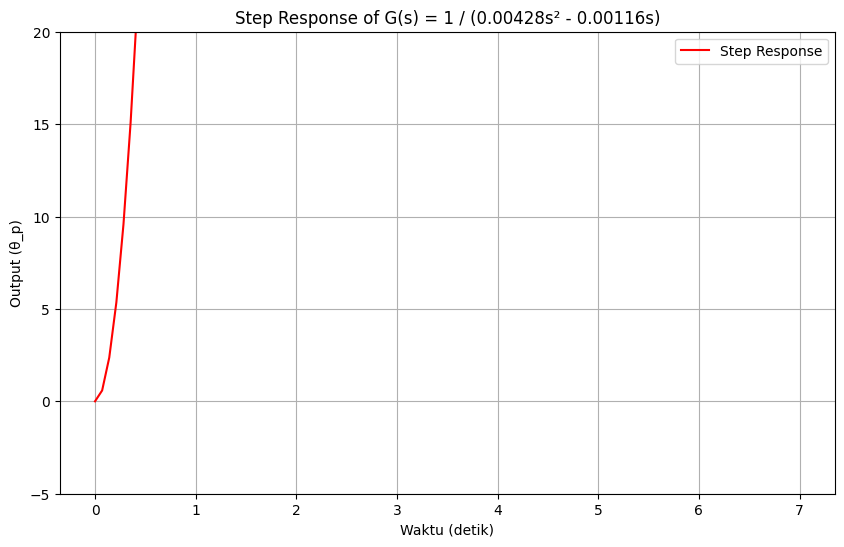

In [64]:
# Import library
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, step

# Koefisien dari transfer function
# G(s) = 1 / (0.00428s^2 - 0.00116s)
numerator = [1]                      # Pembilang
denominator = [0.00428, -0.00116, 0] # Penyebut: 0.00428s^2 - 0.00116s + 0

# Buat transfer function
system = TransferFunction(numerator, denominator)

# Simulasi respon step
t, y = step(system)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t, y, label="Step Response", color='red')
plt.title("Step Response of G(s) = 1 / (0.00428s² - 0.00116s)")
plt.xlabel("Waktu (detik)")
plt.ylabel("Output (θ_p)")
plt.grid(True)
plt.legend()
plt.ylim(-5, 20)  # batasi agar lebih mudah dibaca
plt.show()


In [65]:
%%writefile decision_tree_classifier.py
import numpy as np

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value

class decision_tree_classifier:
    def __init__(self, min_samples_split=2, max_depth=2, mode="gini"):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.mode = mode

    def build_tree(self, dataset, curr_depth = 0):
        X, Y = dataset[:,:-1],dataset[:,-1]
        num_samples, num_features = np.shape(X)
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"] > 0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                return Node(best_split["feature_index"], best_split["threshold"], left_subtree, right_subtree, best_split["info_gain"])
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value = leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_info_gain = -float("inf")
        for feature_index in range (num_features):
            feature_values = dataset[:,feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, self.mode)
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="gini"):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        return self.impurity(parent, mode) - (weight_l * self.impurity(l_child, mode) + weight_r * self.impurity(r_child, mode))

    def impurity(self, y, mode="gini"):
        classes = np.unique(y)
        if mode == "gini":
            gini = 1.0
            for cls in classes:
                p = len(y[y == cls]) / len(y)
                gini -= p ** 2
            return gini
        else:
            entropy = 0
            for cls in classes:
                p = len(y[y == cls]) / len(y)
                entropy -= p * np.log2(p)
            return entropy

    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y.reshape(-1,1)), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)


Overwriting decision_tree_classifier.py


In [66]:
import numpy as np
import pickle
from decision_tree_classifier import decision_tree_classifier

# Dummy dataset
X = np.array([[1, 1], [2, 1], [3, 0], [4, 0]])
y = np.array([0, 0, 1, 1])

model = decision_tree_classifier(max_depth=2)
model.fit(X, y)

# Simpan model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)


In [67]:
from decision_tree_classifier import decision_tree_classifier

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

# Uji
print(model.predict([[1.5, 1]]))  # Contoh prediksi


[np.int64(0)]


/usr/local/lib/python3.11/dist-packages/control/rlocus.py:202: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(


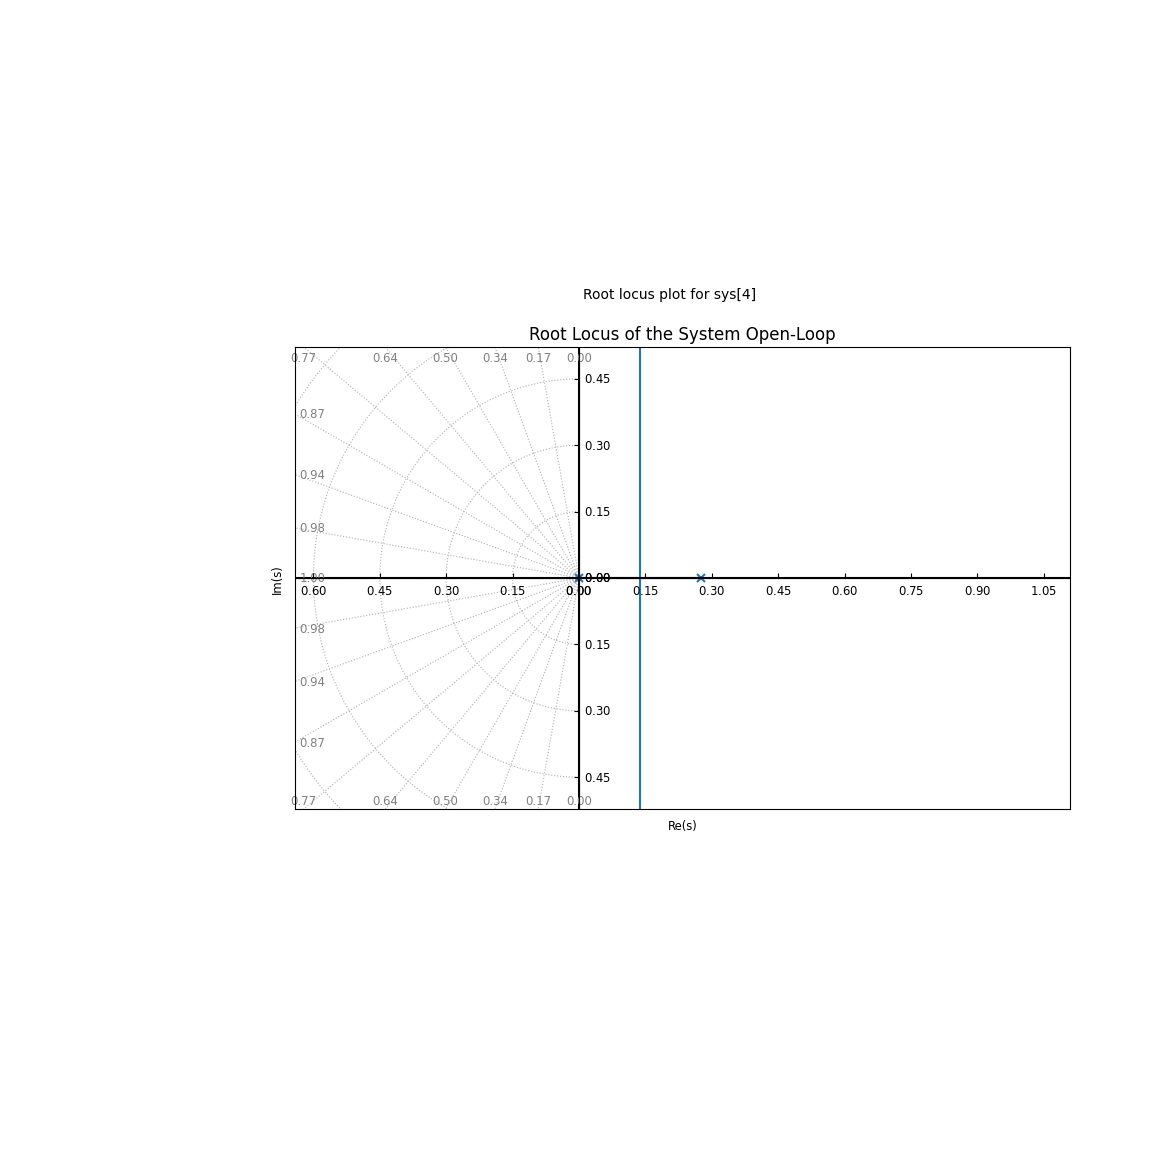

In [68]:
!pip install control

import matplotlib.pyplot as plt
import control as ctrl

# Definisikan transfer fungsi: G(s) = 1 / (0.0042s^2 - 0.00116s)
numerator = [1]
denominator = [0.0042, -0.00116, 0]

# Buat sistem
G = ctrl.TransferFunction(numerator, denominator)

# Plot root locus
plt.figure(figsize=(10,6))
rlist, klist = ctrl.root_locus(G, plot=True, grid=True)
plt.title("Root Locus of the System Open-Loop")
plt.xlabel("Re(s)")
plt.ylabel("Im(s)")
plt.axvline(0, color='black')  # sumbu imajiner
plt.axhline(0, color='black')  # sumbu real
plt.show()


In [78]:

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)



# Membuat Web App sederhana

In [71]:
!pip install streamlit pyngrok
from pyngrok import ngrok

# Token dari https://dashboard.ngrok.com/get-started/setup
ngrok.set_auth_token("30bZtut0W8emUPOG6T4sJ8JjDjf_63iaJViGdxHB6Zt7degzz")



## Menjalankan Aplikasinya

In [79]:
%%writefile app.py
import streamlit as st
import pandas as pd
import pickle

# ===== Styling Tambahan =====
st.markdown("""
    <style>
    body {
        background-color: #f0f2f6;
    }
    .stButton>button {
        background-color: #4CAF50;
        color: white;
        padding: 10px 20px;
        border-radius: 8px;
        font-size: 16px;
    }
    .stButton>button:hover {
        background-color: #45a049;
        color: white;
    }
    .title {
        font-size: 36px;
        text-align: center;
        color: #2E86C1;
        font-weight: bold;
        margin-bottom: 20px;
    }
    </style>
""", unsafe_allow_html=True)

# ===== Judul Aplikasi =====
st.markdown('<div class="title">Prediksi Penyakit Jantung</div>', unsafe_allow_html=True)

# ===== Input Form =====
age = st.number_input("Usia", 20, 100)
sex_option = st.selectbox("Jenis Kelamin", ["Laki-laki", "Perempuan"])
sex = 1 if sex_option == "Laki-laki" else 0
cp = st.selectbox("Chest Pain Type", [0, 1, 2, 3])
trestbps = st.number_input("Resting Blood Pressure")
chol = st.number_input("Serum Cholestoral")
fbs = st.selectbox("Fasting Blood Sugar > 120 mg/dl", [0, 1])
restecg = st.selectbox("Resting ECG", [0, 1, 2])
thalach = st.number_input("Maximum Heart Rate Achieved")
exang = st.selectbox("Exercise Induced Angina", [0, 1])
oldpeak = st.number_input("ST depression")
slope = st.selectbox("Slope of peak", [0, 1, 2])
ca = st.selectbox("Number of major vessels", [0, 1, 2, 3])
thal = st.selectbox("Thal", [0, 1, 2, 3])

# ===== Load Model =====
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

# ===== Prediksi =====
if st.button("Prediksi"):
    data = [[age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang,
             oldpeak, slope, ca, thal]]
    pred = model.predict(data)
    hasil = "POSITIF" if pred[0] == 1 else "NEGATIF"

    if hasil == "POSITIF":
        st.error("⚠️ Hasil prediksi: POSITIF (Kemungkinan ada penyakit jantung)")
    else:
        st.success("✅ Hasil prediksi: NEGATIF (Kemungkinan tidak ada penyakit jantung)")

# ===== Footer =====
st.markdown("""
<hr>
<div style='text-align: center'>
    <small>© 2025 | Dibuat oleh Hensoy | Universitas Airlangga</small>
</div>
""", unsafe_allow_html=True)




Overwriting app.py


In [73]:
!ngrok config add-authtoken 30bZtut0W8emUPOG6T4sJ8JjDjf_63iaJViGdxHB6Zt7degzz


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [74]:
!streamlit run app.py &>/content/log.txt &
from pyngrok import ngrok

# Open a HTTP tunnel on the streamlit port (8501)
public_url = ngrok.connect(8501)
print(f"Akses aplikasi di: {public_url}")



Akses aplikasi di: NgrokTunnel: "https://55fa2deea822.ngrok-free.app" -> "http://localhost:8501"
